# Take-Home Exam Week 5 INFOMCDMMC 2022/2023
*Deadline: Monday 16th before midnight*

## Instructions

* You can score up to 100 points in total (check each question for the respective points assigned).
 
* Provide your answers in this JupyterNotebook. Use the following format for naming the files: SGX_lastname_initials.ipynb (replace X for your respective seminar group [1, 2, 3, 4]. For instance, Mike Martin is in seminar group 2, his file name should be “SG2_martin_m.ipynb”)
 
* Use markdowns for arguments/written answers. Feel free to add new code and text cells.
 
* You have complete freedom in choosing a method that fits the question in focus.
 
* You are allowed to use code from the Python manual and lectures/seminars.
 
* When citing academic literature to support your arguments, please use APA style referencing.
 
* Each question indicates a maximum word count. This concerns the argumentative part and excludes any code in Python.
 
* Ensure that the examiners can execute your code! Inform them about any necessary installations in the notebook. As an orientation: it should be running in Google Colab without issues.
 
* You will be graded on the quality of your arguments and your code (i.e., methodology).
 
* We only require you to apply what we covered in this course so far (up until week 4), but other methods are also allowed. 

# Task One (10 points)

The file Q1_discussions.csv (alternatively Q1_discussions.p) contains a sample of Reddit comments about popular TV shows from 2011 to 2020 (50.000 comments).

## Question 1.1
Based on the provided data, identify the most discussed show for each year.

In [3]:
#Removing warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
#identify most discussed show

import random
random.seed(777)


#Importing libraries to use
#code
#stats
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy  as np
! pip install kneed
from kneed import KneeLocator

#support
import re
import html
import datetime
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import json
from os.path import basename
from zipfile import ZipFile
import string
import pickle


#NLP
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
lemmatizer = nltk.stem.WordNetLemmatizer()

import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load("en_core_web_sm")

from wordcloud import WordCloud

#LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary


#Visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pprint import pprint

#LDA Visualisation (optional)
import pickle
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

! pip install shifterator
import shifterator as sh
import networkx as nx
from collections import defaultdict


[nltk_data] Downloading package stopwords to /Users/kike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kike/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2022-12-19 15:21:27.051315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,year,title,type
0,2011,Breaking Bad,588
1,2012,Breaking Bad,3208
2,2013,Breaking Bad,2627
3,2014,True Detective,563
4,2015,Game of Thrones,4559
5,2016,Game of Thrones,6313
6,2017,Game of Thrones,3903
7,2018,Black Mirror,2427
8,2019,Stranger Things,1450
9,2020,Dark,1458


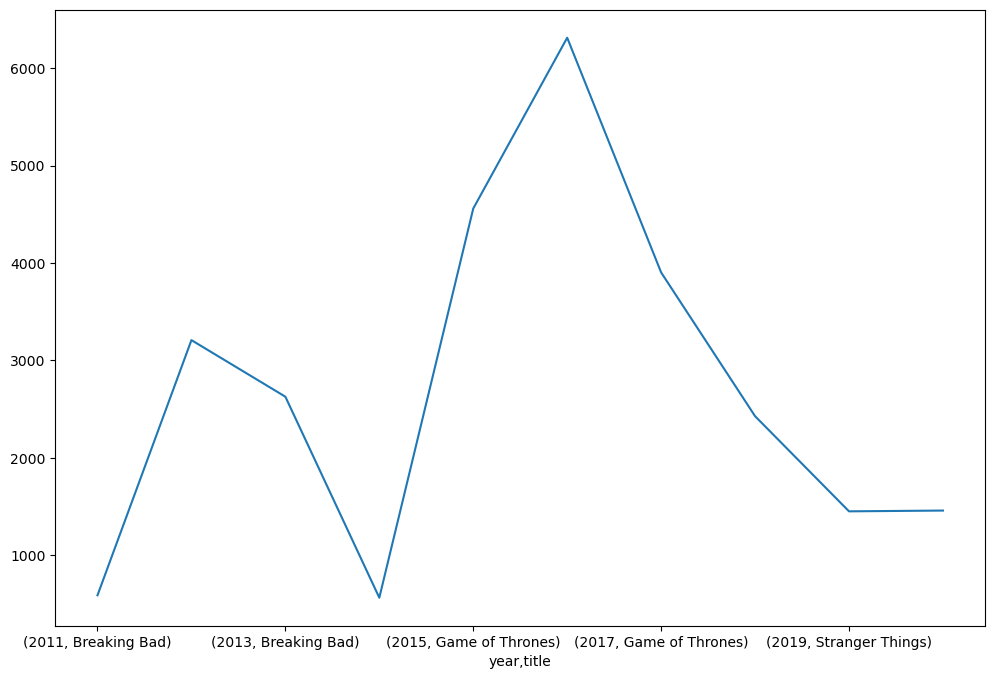

In [ ]:
#identify most discussed show
#Reading data
df = pd.read_csv("Q1_discussions.csv")
df.head(10)

#Drop column unamed
df.drop("Unnamed: 0", axis = 1, inplace = True)

#Group by year and series name
grouped = df.groupby(["year", "title"]).count().sort_values(["year","type"]).groupby(level=0).tail(1)["type"]
grouped.plot(kind='line', figsize = (12, 8))
grouped = grouped.reset_index() 
grouped.rename(columns = {'type':'Count'})
grouped




## Question 1.2

Select a sub-sample of two shows that you are interested in. First, motivate your choice and state a hypothesis about the differences that you expect to find regarding how the shows are being discussed on Reddit.

*ANSWER:* 

The two TV shows selected for analysis are Breaking Bad and Game of Thrones, which were chosen because they are popular and have the bigger number of posts in the dataset. In addition, their plots have a large contrast, so I expect to find significant differences in how people discuss them on Reddit.

For Breaking Bad, I expect to find words that describe the drug empire depicted in the series, while I expect to find more words describing the medieval fantasy setting of Game of Thrones.

According to IMDb, Breaking Bad is ranked second among all TV shows and has a rating of 9.4 (1), while Game of Thrones is ranked 13th and has a rating of 9.1 (2). Therefore, I expect a more positive sentiment towards Breaking Bad in the sentiment analysis, which will assess the overall sentiment of adjectives used in Reddit comments about the shows as positive, neutral, or negative

To test this hypothesis, I will conduct a sentiment analysis that categorizes the adjectives used in Reddit comments about the shows as positive, neutral, or negative in order to estimate the overall sentiment towards the shows.


*REFERENCES:* 

1 Breaking Bad (2008). Retrieved from https://www.imdb.com/chart/toptv/ on December 17th, 2022

2 Game of Thrones (2011). Retrieved from https://www.imdb.com/chart/toptv/ on December 17th, 2022

Compare the comments per selected show in respect to 
* the 20 most used adjectives in comments per show; 
* the most common adjectives in comments per show over the years 2011-2020;
* retrieve the most distinct words per show.

the 20 most used adjectives in comments per show, code below:

In [ ]:
#Getting the list of all show names (might be needed)
List_shows=list(df['title'].value_counts().index)
List_years=list(df['year'].value_counts().index)

#Create the subsets
flatten = lambda t: [item for sublist in t for item in sublist]

#Function to extract adj
def include_features(x):
    include_features = ['ADJ'] #see the table below for explaination of tags, try with different combinations
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])   
    return text

#do nlp
def do_nlp(x):
    doc = nlp(x)
    return doc

#Cleaning function
def clean(x):
    #Lowercasing (this function applies per row)
    x = x.apply(lambda x: x.lower())
    #number elimination (str applies for full series)
    x = x.str.replace(r'\d+', '', regex=True)
    # punctuation elminanition
    x = x.str.replace(r'[^\w\s]', '', regex=True)
    #Space removal (stripping)
    x = x.str.replace(r' +', ' ', regex=True)
    #Stop words remove
    stop = stopwords.words("english")
    x = x.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]) )
    #link removal
    x = x.str.replace(r'http\S+', '', regex=True)
    #Returning 
    return x

#function to count words
from collections import Counter
def count_words(x):
    dic = Counter(flatten(x))          
    return dic

dfa = df.copy()
#Cleaning title column
#Cleaning and extracting just adjectives
nlp = spacy.load("en_core_web_sm")
dfa["post_clean"] = clean(dfa["post"])
dfa["adj"] =  dfa["post"].apply(lambda x: do_nlp(str(x)))
dfa['adj'] = dfa['adj'].apply(lambda x: include_features(x))

#Tokenizing
dfa['tokenized'] = dfa['adj'].apply(nltk.word_tokenize)

#Filtering by series name
serie1 = dfa.loc[dfa["title"].str.contains("Breaking Bad")]
serie2 = dfa.loc[dfa["title"].str.contains("Game of Thrones")]

#Defining counting and ordering function
def top(dic):
    tag_freq = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    breaking_top20 = pd.DataFrame(tag_freq.items(), columns=["word", "count"])

    return breaking_top20
    
#Counting breaking bad words
serie1_dic = count_words(serie1["tokenized"])
print("Top 20 adjectives of Breaking Bad")
top_serie1 = top(serie1_dic).head(20)

#Download and setup lexicon
nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())

#sentiment scoring function
def sentiment_evaluate(x):
    sen = 0
    if x in pos_list:
        sen = 1
    if x in neg_list:
        sen = - 1
    return sen

#Calculating sentiment score of sentiment * count of top 20 adjectives
top_serie1["sentiment"] = top_serie1["word"].apply(sentiment_evaluate)
top_serie1["sentiment score"] = top_serie1["count"] *  top_serie1["sentiment"]
display(top_serie1)
print("average sentiment towards Breaking Bad in the top 20 adjectives", (top_serie1["sentiment score"].mean()))

#Counting Game of Thrones
serie2_dic = count_words(serie2["tokenized"])
print("Top 20 adjectives of Game of Thrones")
top_serie2 = top(serie2_dic).head(20)

#Calculating sentiment score of sentiment * count of top 20 adjectives
top_serie2["sentiment"] = top_serie2["word"].apply(sentiment_evaluate)
top_serie2["sentiment score"] = top_serie2["count"] *  top_serie2["sentiment"]
display(top_serie2)
print("average sentiment towards Game of Thrones", (top_serie2["sentiment score"].mean()))

Top 20 adjectives of Breaking Bad


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/kike/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


,word,count,sentiment,sentiment score
0,good,117,1,117
1,last,115,0,0
2,sure,107,0,0
3,bad,107,-1,-107
4,first,104,0,0
5,much,94,0,0
6,more,92,0,0
7,same,87,0,0
8,other,83,0,0
9,only,81,0,0


average sentiment towards Breaking Bad in the top 20 adjectives 3.35
Top 20 adjectives of Game of Thrones


,word,count,sentiment,sentiment score
0,good,405,1,405
1,more,342,0,0
2,dead,332,-1,-332
3,other,324,0,0
4,last,318,0,0
5,sure,261,0,0
6,little,250,0,0
7,same,246,0,0
8,first,233,0,0
9,whole,230,0,0


average sentiment towards Game of Thrones 1.55


the most common adjectives in comments per show over the years 2011-2020:

In [ ]:
#Creating empty dataframe
serie1_df = pd.DataFrame(columns = ["year", "word"])
serie2_df = pd.DataFrame(columns = ["year", "word"])

#Filtering by series name
serie1 = dfa.loc[dfa["title"].str.contains("Breaking Bad")]
serie2 = dfa.loc[dfa["title"].str.contains("Game of Thrones")]

#Little bug to fix str to int in df
def make_int(x):
    integer = int(x)
    return integer

#Iterate along the year list
for year in List_years:

  #If the serie was commented along that year it will work
    try:
        #Getting df from just the year selected
        serie1_year =  serie1.loc[serie1["year"]== year]
        serie2_year = serie2.loc[serie2["year"]== year]


        #Counting breaking bad
        serie1_dic = count_words(serie1_year["tokenized"])
        top1 = top(serie1_dic).head(20)
        top1["year"] = year
        serie1_df = pd.concat([serie1_df,top1], axis = 0)


        #Counting game of thrones
        serie2_dic = count_words(serie2_year["tokenized"])
        top2 = top(serie2_dic).head(20)
        top2["year"] = year
        serie2_df = pd.concat([serie2_df,top2], axis = 0)
    except: pass

#Calculating sentiment score and average per year
top_year_1 = serie1_df.sort_values(by=['year'])
top_year_1["sentiment"] = top_year_1["word"].apply(sentiment_evaluate)
top_year_1["sentiment score"] = top_year_1["count"] *  top_year_1["sentiment"]
top_year_1["sentiment score"]= top_year_1["sentiment score"].apply(make_int)
y_sum1 = top_year_1.groupby("year").mean()
y_sum1 = y_sum1.reset_index()
print("Breaking Bad top words per year")
display(top_year_1)
print("Sentiment average per year")
display(y_sum1)

#Calculating sentiment score and average per year
top_year_2 = serie2_df.sort_values(by=['year'])
top_year_2["sentiment"] = top_year_2["word"].apply(sentiment_evaluate)
top_year_2["sentiment score"] = top_year_2["count"] *  top_year_2["sentiment"]
y_sum = top_year_2.groupby("year").mean()
y_sum = y_sum.reset_index()
print("Game of Thrones top words per year")
display(top_year_2)
print("Sentiment average per year")
display(y_sum)

Breaking Bad top words per year


,year,word,count,sentiment,sentiment score
19,2011,right,7,1,7
1,2011,much,16,0,0
2,2011,sure,15,0,0
3,2011,first,13,0,0
4,2011,good,13,1,13
5,2011,best,12,1,12
6,2011,more,12,0,0
7,2011,last,11,0,0
8,2011,new,10,0,0
9,2011,other,10,0,0


Sentiment average per year


,year,sentiment,sentiment score
0,2011,0.20,1.95
1,2012,0.00,1.15
2,2013,0.05,0.05


Game of Thrones top words per year


,year,word,count,sentiment,sentiment score
1,2015,other,129.0,0,0.0
2,2015,more,122.0,0,0.0
3,2015,last,117.0,0,0.0
4,2015,dead,104.0,-1,-104.0
5,2015,sure,88.0,0,0.0
...,...,...,...,...,...
2,2019,much,18.0,0,0.0
1,2019,same,21.0,0,0.0
18,2019,short,7.0,0,0.0
8,2019,other,11.0,0,0.0


Sentiment average per year


,year,count,sentiment,sentiment score
0,2015,81.80,0.00,0.40
1,2016,95.80,0.00,0.35
2,2017,56.25,0.05,2.65
3,2019,11.75,0.10,1.05


retrieve the most distinct words per show:

In [ ]:
from collections import Counter
import spacy
import pandas as pd

from tqdm import tqdm_notebook
from scipy.stats import chi2_contingency

#Create the subsets
flatten = lambda t: [item for sublist in t for item in sublist]
dfa = df.copy()

#Cleaning
dfa["newpost"] = clean(dfa["post"])
#Tokenizing
dfa['tokenized'] = dfa['newpost'].apply(nltk.word_tokenize)

#Filtering by series name
serie1 = dfa.loc[dfa["title"].str.contains("Breaking Bad")]
serie2 = dfa.loc[dfa["title"].str.contains("Game of Thrones")]

#Flattening
serie1 = flatten(serie1["tokenized"])
serie2 = flatten(serie2["tokenized"])

#Defining function of Count + Log Likelihood
def distinctive_words(target_corpus, reference_corpus):
    counts_c1 = Counter(target_corpus) # don't forget to flatten your texts!
    counts_c2 = Counter(reference_corpus)
    vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))
    freq_c1_total = sum(counts_c1.values()) 
    freq_c2_total = sum(counts_c2.values()) 
    results = []
    for word in vocabulary:
        freq_c1 = counts_c1[word]
        freq_c2 = counts_c2[word]
        freq_c1_other = freq_c1_total - freq_c1
        freq_c2_other = freq_c2_total - freq_c2
        llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                      [freq_c1_other, freq_c2_other]],
                      lambda_='log-likelihood') 
        if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
            llr = -llr
        result = {'word':word, 
                    'llr':llr,
                    'p_value': p_value}
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

#compare results
results_comp = distinctive_words(serie1, serie2)

# distinctive for Serie1
print("Most distinctive words for Breaking Bad")
display(results_comp.sort_values('llr', ascending=False).head(20))

# distinctive for Serie2
print("Most distinctive words for Game of Thrones")
display(results_comp.sort_values('llr', ascending=True).head(20))


Most distinctive words for Breaking Bad


,word,llr,p_value
11861,walt,3004.930050,0.000000e+00
4954,jesse,1741.986991,0.000000e+00
8795,hank,998.688940,3.461332e-219
5465,mike,692.182333,1.498721e-152
2616,gus,620.294690,6.451537e-137
7031,todd,455.349025,4.943502e-101
9861,walts,455.349025,4.943502e-101
2850,skyler,442.056005,3.863516e-98
13346,walter,368.834218,3.357547e-82
15313,meth,367.645296,6.093832e-82


Most distinctive words for Game of Thrones


,word,llr,p_value
18088,jon,-638.746134,6.260917e-141
10017,arya,-382.466799,3.613307e-85
7928,sansa,-298.889676,5.750095e-67
12480,dany,-274.946842,9.479862e-62
5306,cersei,-230.423016,4.820480e-52
14922,dragon,-209.939090,1.416298e-47
9422,bran,-199.353240,2.890483e-45
9573,king,-196.622498,1.140011e-44
763,removed,-185.439234,3.147096e-42
15622,stannis,-184.827003,4.281193e-42


## Question 1.3

Discuss your observations: point out what we can learn from these analyses but also what their limitations are. What additional analyses would be needed for more insightful results? The written answers should not exceed 350 words in total.

*ANSWER:* 

Kilgarriff (2012) states that the frequency of keywords can be used to compare two corpora. However, in the first assignment, finding the top 20 adjectives used in the show's posts did not yield significant results as they seemed redundant between the series. The sentiment analysis also did not provide significant insights for comparison. Rice et al. (2019) pointed that the validity of sentiment analysis using dictionary approaches depends on the quality and comprehensiveness of the dictionary in reflecting the sentiment in the texts it is applied to. In this case, using specifically built dictionaries for series reviews might yield better insights for comparison.

For the second assignment, some adjectives and sentiment scores were observed over the years, possibly indicating some kind of acceptance difference among the public for specific seasons of the shows. However, since this sentiment analysis is limited to positive and negative sentiment and word count, the proposed sentiment score (sentiment * count) might not be the ideal indicator for this purpose.

In my opinion, the third assignment provided the most insights. Using log-likelihood between the words in the comments for both TV shows, we can identify characters from both series, as well as characteristic nouns such as "meth" and "money" for "Breaking Bad" and "dragon" and "battle" for "Game of Thrones." However, it is important to note that log likelihood values are affected by the size of the corpora: a larger sample size will generally result in a higher log likelihood, even if the model is not a good fit to the data (Pojanapunya et al., 2018).

To get better results in the first two assignments, it would be beneficial to include a wider variety of lexical categories such as nouns, verbs, and adverbs to have a greater range of the top words used in the documents. Performing a more advanced sentiment analysis with a wider variety of terms and sentiments would also be useful in analyzing the TV shows and could lead to interesting insights.


*REFERENCES:* 

Kilgarriff, A (2012). Getting to know your corpus. Brighton, UK. Lexical Computing Ltd

RICE, D.R., ZORN,C (2019). Corpus-based dictionaries for sentiment analysis of
specialized vocabularies. Amherst, Massachusetts, United States. Political Science Research and Methods 

Pojanapunya, P.,  Watson,R. (2018) Log-likelihood and odds ratio: Keyness
statistics for different purposes of keyword analysis. Iowa State University. Corpus Linguistics and Ling. Theory 2018; 14(1): 133–167


# Task Two (40 points)

The file Q2_tech_tweets.csv contains 300.000 tweets that mention either “China” or “India” in combination with the term “tech”, posted between 2010 and 2021. The data include the tweets, usernames, users mentioned in a tweet, date of posting and a range of interaction metrics (e.g., likes, replies). Your task is to explore how “tech” is **framed** differently in the Indian and Chinese contexts. 

*PLEASE NOTE: The file Q2_tech_tweets.csv (also .p) is about 700 MB.*

## Quesiton 2.1

With reference to the learning materials from this course, explain how "framing" is defined and operationalized in your analysis.  

*ANSWER:*

Frame is a way of highlighting certain aspects of a perceived reality in order to present a specific interpretation of a problem, its causes, moral implications, and recommended solutions.(Kohring & Matthes, 2002).  These aspects, called frame elements, can be identified and analyzed through content analysis and cluster analysis. (Entman 1993)
 
In my opinion, framing refers to the overall perception of an entity or issue by society, which may be influenced by a powerful group and can be consciously or unconsciously modified by them. 
Framing can be useful for understanding how an organization is perceived in different countries and for making data-driven decisions about how to strengthen its market position. 
 
In this study, unsupervised machine learning techniques will be used to analyze tweets about a particular technology organization in China and India in order to identify the frame surrounding it in each country. This will involve performing entity recognition on the tweets dataset to identify the most frequently mentioned organization and then applying techniques such as k-means clustering and dictionary-based sentiment analysis to reveal the frame.
 
*REFERENCES:* 

Entman, R. M. (1993): ‘Framing. Toward Clarification of a Fractured Paradigm’, in
Journalof Communication43 (4), 51-58.
 
Matthes, J. and Kohring, M. (2008): ‘The Content Analysisof Media Frames. Toward
Improving Reliability and Validity’, inJournal of Communication58, 258-279.



## Question 2.2

Conducting a framing analysis with at least **two** different methods for (unsupervised) text analysis. Explain briefly how each method connects to your overall research goals. Ensure that you indicate how you set the key parameters for each method that you apply and justify your choices via commenting. 

*ANSWER:* 

The aim of this study is to determine the most frequently mentioned technology organizations in tweets about China and India, and to analyze the way these organizations are discussed. 

To identify the top tech organizations, we will use the Spacy nlp entity recognition tool to observe the most frequently mentioned organizations. A  iterative preprocessing  with stop words will be used to deal with initial results that were not organizations. Since we do not have information about the location of the tweets, we will use regular expressions to extract keywords and identify co-occurrences of organizations and the countries of interest. 

To perform framing analysis, we will use k-means clustering to divide the overall topics discussed about the top organization into segments, and we will use an elbow plot to determine the optimal number of clusters (Kodinariya et al. 2013). We will also use a lexicon dictionary to perform sentiment analysis and determine the overall positive or negative sentiment towards the top organization in the selected countries. The sentiment analysis will classify the opinions in the text using a dictionary-based method that assigns sentiment scores to opinion words based on their positive, negative, or neutral score (Hardeniya et al. 2016).

*REFERENCES:* 

Kodinariya, T.M, Makwana P.R. (2013) Review on determining number of Cluster in K-Means Clustering. GRMECT Research Center Rajkot - India . International Journal of Advance Research in Computer Science and Management Studies. Volume 1, Issue 6

Hardeniya,T. , Borikar D.A. (2016) Dictionary Based Approach to Sentiment Analysis. International Journal of Advanced Engineering, Management and Science (IJAEMS).  A Review. Vol-2, Issue-5



In [6]:
#answer to question 2.2

#Reading df
df = pd.read_csv("Q2_tech_tweets.csv", error_bad_lines=False, engine="python")
#Importing some libraries to use
import random

#Building subsets by words matching in columns tweet
dfa = df.copy()

#Cleaning
dfa["newtweet"] = clean(dfa["tweet"])

#Checking country mention with regex
dfa["china"] = dfa["newtweet"].str.contains(r'(( ?\bchina\b ?| ?\bChinese\b ?).*?)', regex=True)
dfa[["newtweet", "china"]].head(3)

#Checking country mention with regex
dfa["india"] = dfa["newtweet"].str.contains(r'(( ?\bindia\b ?| ?\bindian\b ?).*?)', regex=True)
dfa[["newtweet", "india"]].head(3)

#sampling by mention
df_china = dfa.loc[dfa["china"]==True]
df_india = dfa.loc[dfa["india"]==True]


#removing redundancy with new stopwords
stop_words = stopwords.words('english')
#Adding stop words from several iterations
new_sw = ['china', 'chinese',"india", "indian","rt","tech","news","rudyguliani", "Rudygiuliani", "g", "rudygiuliani","chinas"]
stop_words.extend(new_sw)

#New cleaning stop words function
def clean_stop(x):
    #Stop words remove
    stop = stop_words
    x = x.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]) )
    #Returning 
    return x

#Cleaning from selected stop words
df_china["newtweet"]  = clean_stop(df_china["newtweet"])
df_india["newtweet"]  = clean_stop(df_india["newtweet"] )

#Security copy of datasets
df_china_sample = df_china.copy()
df_india_sample = df_india.copy()

Analysis For China

Top 15 ORGs in China Tweets


,word,count
0,apple,1563
1,reuters,1292
2,android,932
3,cnn,589
4,microsoft,564
5,samsung,549
6,xiaomi,488
7,eu,460
8,times,456
9,ibm,432


(-0.5, 399.5, 199.5, -0.5)

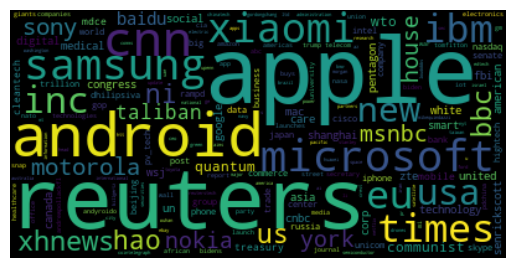

In [ ]:
#Entity recognition
#We are going select the top mentioned organization/company in tweets containing "china"


#Importing libraries
from itertools import combinations
import spacy
import en_core_web_sm

#Create the subsets
flatten = lambda t: [item for sublist in t for item in sublist]

#function to count words
from collections import Counter
def count_words(x):
    dic = Counter(flatten(x))          
    return dic

#Function to extract Entities
def include_features(x):
    include_features = ['ORG'] #selected organizations and companies
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.ent_type_ in include_features])   
    return text

#Do Nlp
def do_nlp(x):
    doc = nlp(x)
    return doc

#Extracting just the ORGs
df_china_sample["Product"] =  df_china_sample["newtweet"].apply(lambda x: do_nlp(str(x)))
df_china_sample['Product'] = df_china_sample['Product'].apply(lambda x: include_features(x))

#Tokenizing
df_china_sample['tokenized'] = df_china_sample['Product'].apply(nltk.word_tokenize)

#Defining counting and ordering function
def top(dic):
    tag_freq = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    breaking_top20 = pd.DataFrame(tag_freq.items(), columns=["word", "count"])

    return breaking_top20

#Counting words
df_china_dic = count_words(df_china_sample["tokenized"])
print("Top 15 ORGs in China Tweets")
display(top(df_china_dic).head(15))
top50 = top(df_china_dic).head(15)

#Generating a Nice style Visualization for top companies mentioned along with "china"
wc = WordCloud().generate_from_frequencies(df_china_dic) #the first two terms are not included in the WordCloud.
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

In [ ]:
#Sentiment Analysis


#Getting just the tweets with the top org/product["Apple"]
df_top_adj =  df_china_sample.copy()
df_top_adj["apple"] = df_top_adj["newtweet"].str.contains(r'(( ?\bapple\b ?).*?)', regex=True)
df_top_adj = df_top_adj.loc[df_top_adj["apple"]==True]

#Create the subsets
flatten = lambda t: [item for sublist in t for item in sublist]

#Function to extract adjectives 
def include_features(x):
    include_features = ['ADJ'] #see the table below for explaination of tags, try with different combinations
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])   
    return text

#do nlp
def do_nlp(x):
    doc = nlp(x)
    return doc

#Getting adjectives mentioned with apple in tweets containing china
df_top_adj["adj"] =  df_top_adj["newtweet"].apply(lambda x: do_nlp(str(x)))
df_top_adj['adj'] = df_top_adj['adj'].apply(lambda x: include_features(x))

#Tokenizing
df_top_adj['tokenized'] = df_top_adj['adj'].apply(nltk.word_tokenize)

#Defining counting and ordering function
def top(dic):
    tag_freq = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    breaking_top20 = pd.DataFrame(tag_freq.items(), columns=["word", "count"])

    return breaking_top20
    
#Counting Top 20 adjectives for tweets with the ORG apple in china
df_top_adj_dic = count_words(df_top_adj["tokenized"])
print("Top 15 adjectives for tweets with the ORG apple in china")
top_adj = top(df_top_adj_dic)

#Doing sentiment Analysis
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())
def sentiment_evaluate(x):
    sen = 0

    if x in pos_list:
        sen = 1
    if x in neg_list:
        sen = - 1
    return sen

top_adj["sentiment"] = top_adj["word"].apply(sentiment_evaluate)
top_adj["sentiment score"] = top_adj["count"] *  top_adj["sentiment"]
top_adj.head(15)

print("Average sentiment towards Apple in tweets containing china", (top_adj["sentiment score"].mean()))
print("Near neutral sentiment")

Top 15 adjectives for tweets with the ORG apple in china
Average sentiment towards Apple in tweets containing china 0.025374855824682813
Slightly positive


In [1]:
print("Near neutral sentiment")

Near neutral sentiment


12
Topics of tweets mentioning Apple and China
0,grows,faster,timesofindia,solar,times,via,size,bhavikbhavsar,yes,true,first,toi_tech,business,iphone,cook,
1,mobile,iphone,cash,add,users,skirts,hoards,iphones,talks,agreement,million,samsung,aapl,socialmedia,talking,
2,us,pay,via,google,technology,new,stores,market,iphones,xiaomi,socialmedia,business,says,samsung,smartphone,
3,ceo,huawei,ren,zhengfei,says,comfortablysmug,protest,bowing,incredible,straight,steal,doesnt,american,retaliates,face,
4,tim,cook,ceo,conditions,improve,plants,tuesday,said,worlds,vows,valua,visits,driving,talks,sales,
5,testify,ties,congressional,hearing,tiktok,decline,washingtonpost,probing,techs,second,raise,earthquake,donation,following,leading,
6,ipad,trademark,dispute,firm,mini,ban,export,lawyer,sell,may,face,reuters,proview,name,loses,
7,deal,mobile,iphone,cs,reportedly,ever,biggest,ship,larger,verizon,cnnmoney,would,today,already,users,
8,wikileaks,counterfeits,vs,act,slow,booming,counterfeit,industry,wlfi

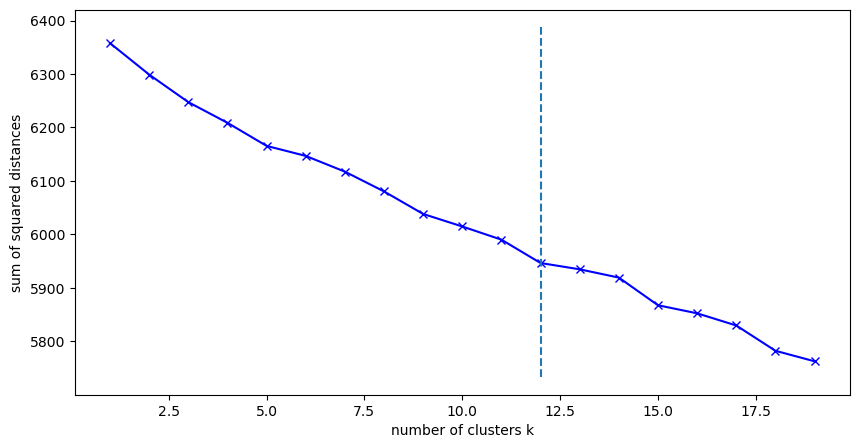

In [ ]:
#Topic Modeling about Apple in tweets containing china


#Vectorization tf_idf  for clickbait
tfidf_vectorizer= TfidfVectorizer(min_df=5, max_df=0.5, norm = "l2") #min_df max_df can be float or int
vectorizer = tfidf_vectorizer.fit_transform(df_top_adj["newtweet"])

#Creating tf idf matrix
tf_idf = pd.DataFrame (data = vectorizer.toarray(), columns = tfidf_vectorizer.get_feature_names_out())
from kneed import KneeLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster

#Calculate kmeans
inertia = []
K = range(1,20)
for k in K:
    
    kmeanModel = KMeans(n_clusters = k, random_state=0)
    kmeanModel.fit(tf_idf)
    inertia.append(kmeanModel.inertia_)
    
#Calculating the knee
from kneed import KneeLocator
kn = KneeLocator(K, inertia, curve = "convex", direction = "decreasing")
print(kn.knee)

#Plotting knee
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.xlabel("number of clusters k")
plt.ylabel("sum of squared distances")
plt.plot(K, inertia, "bx-")
plt.vlines(kn.knee, plt.ylim()[0],plt.ylim()[1],linestyles="dashed" )

#code of clustering
clusters = kn.knee
kmeanModel = KMeans(n_clusters = clusters, init = "k-means++", max_iter = 3000, random_state = 0)
mod = kmeanModel.fit_transform(tf_idf)
df_top_adj["k_means"] = kmeanModel.predict(tf_idf)

print("Topics of tweets mentioning Apple and China")

#Top words per cluster
order_centroids = kmeanModel.cluster_centers_.argsort()[:,::-1]
terms = tfidf_vectorizer.get_feature_names()
dict = []
for i in range(clusters):
    print("%d" % i, sep ="", end = "," ), 
    for ind in order_centroids[i, :15]:
        print (terms[ind], sep ="", end = ",")
    print("")
    
#Topic distribution
print("Distribution of topics")
count = df_top_adj.groupby("k_means").size()
print(count)


Analysis For India

Top 15 ORGs in India Tweets


,word,count
0,samsung,2119
1,android,1774
2,times,1474
3,microsoft,1287
4,apple,1169
5,nokia,1143
6,xiaomi,858
7,sony,846
8,ibm,638
9,usa,583


(-0.5, 399.5, 199.5, -0.5)

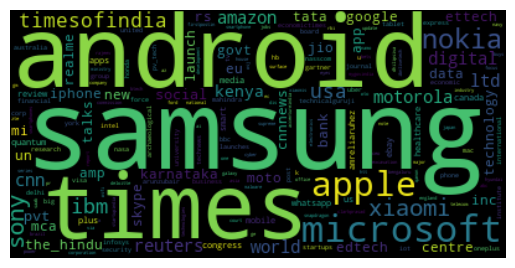

In [ ]:
#Entity recognition

from itertools import combinations
import spacy
import en_core_web_sm

#Function to extract Entities
def include_features(x):
    include_features = ['ORG'] #selected organizations and companies
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.ent_type_ in include_features])   
    return text

#Extracting just the ORGs
df_india_sample["Product"] =  df_india_sample["newtweet"].apply(lambda x: do_nlp(str(x)))
df_india_sample['Product'] = df_india_sample['Product'].apply(lambda x: include_features(x))

#Tokenizing
df_india_sample['tokenized'] = df_india_sample['Product'].apply(nltk.word_tokenize)

#Defining counting and ordering function
def top(dic):
    tag_freq = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
    breaking_top20 = pd.DataFrame(tag_freq.items(), columns=["word", "count"])

    return breaking_top20

#Counting words
df_india_dic = count_words(df_india_sample["tokenized"])
print("Top 15 ORGs in India Tweets")
display(top(df_india_dic).head(15))
top50 = top(df_india_dic).head(15)

#Generating a nice style visualization for top companies mentioned along with "india"
wc = WordCloud().generate_from_frequencies(df_india_dic) #the first two terms are not included in the WordCloud.
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

In [ ]:
#Sentiment Analysis


#Getting just the tweets with the top org/product["Samsung"]
df_top_adj =  df_india_sample.copy()
df_top_adj["apple"] = df_top_adj["newtweet"].str.contains(r'(( ?\bsamsung\b ?).*?)', regex=True)
df_top_adj = df_top_adj.loc[df_top_adj["apple"]==True]

#Create the subsets
flatten = lambda t: [item for sublist in t for item in sublist]

def include_features(x):
    include_features = ['ADJ'] 
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])   
    return text

def do_nlp(x):
    doc = nlp(x)
    return doc

#Getting just adjectives 
df_top_adj["adj"] =  df_top_adj["newtweet"].apply(lambda x: do_nlp(str(x)))
df_top_adj['adj'] = df_top_adj['adj'].apply(lambda x: include_features(x))
#Tokenizing
df_top_adj['tokenized'] = df_top_adj['adj'].apply(nltk.word_tokenize)

#Counting 
df_top_adj_dic = count_words(df_top_adj["tokenized"])
print("Top 20 adjectives for tweets with the product samsung in India")
top_adj = top(df_top_adj_dic)

#Sentiment analysis
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())
top_adj["sentiment"] = top_adj["word"].apply(sentiment_evaluate)
top_adj["sentiment score"] = top_adj["count"] *  top_adj["sentiment"]
top_adj.head(50)

print("average sentiment towards samsung in India", (top_adj["sentiment score"].mean()))
print("Positive")

Top 20 adjectives for tweets with the product samsung in India
average sentiment towards samsung in India 0.7343358395989975
Positive


11
Topics of tweets mentioning Samsung and India
0,apple,times,iphone,patent,beat,vs,wins,timesofindia,ipad,us,suit,billion,dollar,ceo,war,
1,launched,price,rs,galaxy,tab,specifications,priced,grand,cut,specification,camera,slashes,cameras,features,inch,
2,launches,rs,galaxy,times,grand,phones,biggest,phablet,timesofindia,expensive,smartphone,tab,gear,starting,note,
3,smartphone,samsungmobile,market,times,xiaomi,top,apple,micromax,still,idc,economic,galaxy,share,take,maker,
4,note,galaxy,ii,times,update,iii,android,gear,new,leaked,cheaper,launch,unveils,today,rs,
5,edge,galaxy,launched,know,need,financial,heres,made,price,express,launch,today,sources,arrive,april,
6,times,galaxy,unveils,ban,phones,report,timesofindia,iphone,iii,facing,google,immediate,eight,sales,camera,
7,phone,times,tizen,galaxy,android,golden,mi,launch,folding,malware,paytm,new,unveils,mobile,talks,
8,launch,galaxy,april,times,date,today,may,expected,set,new,price,report,smartphones,smartphone,ahead,
9,talks,redmi,t

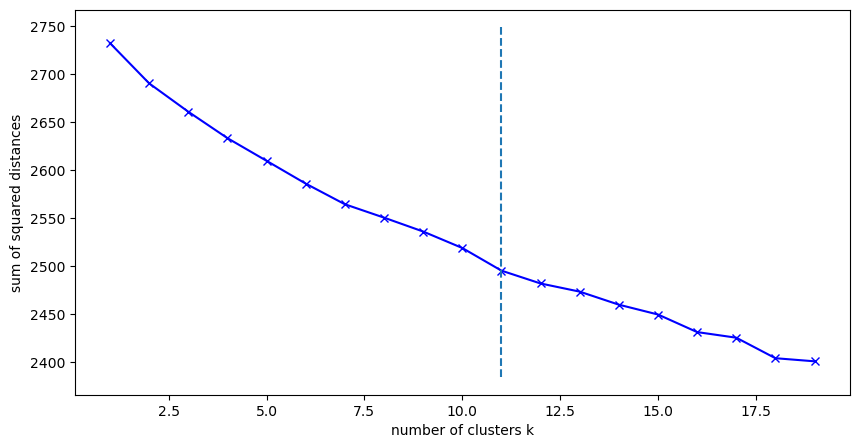

In [ ]:
##Topic Modeling about Samsung in tweets containing India


#Clusterinig for India
#Vectorization tf_idf  for clickbait
tfidf_vectorizer= TfidfVectorizer(min_df=5, max_df=0.5, norm = "l2") #min_df max_df can be float or int
vectorizer = tfidf_vectorizer.fit_transform(df_top_adj["newtweet"])
#Creating tf idf matrix
tf_idf = pd.DataFrame (data = vectorizer.toarray(), columns = tfidf_vectorizer.get_feature_names_out())
from kneed import KneeLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster
#Calculate kmeans
inertia = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters = k, random_state=0)
    kmeanModel.fit(tf_idf)
    inertia.append(kmeanModel.inertia_)
    
#Calculating the knee
from kneed import KneeLocator
kn = KneeLocator(K, inertia, curve = "convex", direction = "decreasing")
print(kn.knee)

#Plotting knee
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.xlabel("number of clusters k")
plt.ylabel("sum of squared distances")
plt.plot(K, inertia, "bx-")
plt.vlines(kn.knee, plt.ylim()[0],plt.ylim()[1],linestyles="dashed" )

#K mean-Clustering
clusters = kn.knee
kmeanModel = KMeans(n_clusters = clusters, init = "k-means++", max_iter = 3000, random_state = 0)
mod = kmeanModel.fit_transform(tf_idf)
df_top_adj["k_means"] = kmeanModel.predict(tf_idf)
print("Topics of tweets mentioning Samsung and India")

#Top words per cluster
order_centroids = kmeanModel.cluster_centers_.argsort()[:,::-1]
terms = tfidf_vectorizer.get_feature_names()
dict = []
for i in range(clusters):
    print("%d" % i, sep ="", end = "," ), 
    for ind in order_centroids[i, :15]:
        print (terms[ind], sep ="", end = ",")
    print("")
    
#Distribution of topics
print("Distribution of topics")
count = df_top_adj.groupby("k_means").size()
print(count)



## Question 2.3

Discuss your results critically: what can we learn about the dicussion of technologies in the Indian and Chinese cases? What are the limitations of your chosen methods but also the data? The written answers should not exceed 500 words in total.


*ANSWER:* 

The first part of the investigation, entity recognition, led to insightful results about the principal organizations being discussed in tweets with the words "China" and "India," respectively. Although the results of this part do not lead to complex results by themselves (just a simple count of words), a word cloud was generated to visually illustrate these organizations. For China, we found that Apple is the most mentioned, while for India it is Samsung.

After recognizing the top organizations per country, the topic framing showed that some impressive and unexpected conversation topics about the organizations emerged. For example, in addition to topics like devices, services, and the growth of the trademark, Apple has been discussed in political issues and some executive names and their competitors appear in the frame. In India, the topics surrounding Samsung are more limited to launches, devices, economic aspects, and competitors.The overall sentiment in India towards Samsung appears to be more positive than the sentiment towards Apple in China, which tends to be neutral.

One of the challenges in creating subsets of data was that the information about the source location of the tweets was not available. Using regular expressions to obtain country keywords only led to a certain portion of the data and sometimes data from other sources, which created a bias and we cannot assure that the tweets were directly generated from that country, but only the co-occurrence of both words in the same tweet.
Lossio-Ventura et al., (2021) denote that one limitation of K-means is that clustering methods can be difficult to use effectively on high-dimensional datasets due to the "curse of dimensionality," and clustering short text poses additional challenges because the data is often sparse. Furthermore, determining the correct number of clusters to use in K-means is also a challenge, and the elbow analysis method can be used to identify the optimal number of clusters, although it is not always reliable and the correct number of clusters depends on the specific case study (Kodinariya et al., 2013).

According to Hardeniya (2016), using dictionary approaches for determining sentiment analysis might lead to certain natural language processing issues, such as dealing with negation words and words that are context-dependent. Moreover, Rice et al. (2019) indicate that the validity of sentiment analysis using dictionary approaches depends on the quality and comprehensiveness of the dictionary in reflecting the sentiment in the texts it is applied to. In this case, the specific objective for the organization or product should be delimited to use the correct lexicon.

Finally, it would be useful to investigate the source of the dataset and answer some critical questions to assess its degree of validity, such as how it was collected, whether it represents all the tweets generated during the period, the biases introduced by the sample, and how missing data was handled.


*REFERENCES:* 

Hardeniya,T. , Borikar D.A. (2016) Dictionary Based Approach to Sentiment Analysis. International Journal of Advanced Engineering, Management and Science (IJAEMS).  A Review. Vol-2, Issue-5

Lossio-Ventura,J.A., Gonzales, S. (2021). Evaluation of clustering and topic modeling methods over health-related tweets and emails. ​​Stanford Center for Biomedical Informatics Research. Artificial Intelligence In Medicine 117

Kodinariya, T.M, Makwana P.R. (2013) Review on determining number of Cluster in K-Means Clustering. GRMECT Research Center Rajkot - India . International Journal of Advance Research in Computer Science and Management Studies. Volume 1, Issue 6

RICE, D.R., ZORN,C (2019). Corpus-based dictionaries for sentiment analysis of
specialized vocabularies. Amherst, Massachusetts, United States. Political Science Research and Methods 


# Task Three (20 points)

The file Q3_clickbait.csv contains ca. 32.000 articles titles that were labelled for either “clickbait” or “no-clickbait” (binary labelling, 1= “clickbait”, 0= “no-clickbait”). Your task is to dive a bit deeper into what features make a title "clickbait".

## Question 3.1

Identify the top 15 NOUNS most strongly associated with “clickbait”. Choose a method for pre-processing the texts prior to analysis that allows you to do this. Discuss and explain why these words are indicative for the “clickbait” category (or why not). Does it make sense to focus on NOUNS only?

*ANSWER:* 

The Spacy NLP library was used to extract nouns from the corpora. The Counter and Tf-idf approaches were then used to vectorize the data, and both approaches yielded similar results. 

Geçkil et al. (2018) define clickbait as a technique that manipulates a person's curiosity to get them to open more pages on a website, often through exaggerated and unrealistic headlines. Logistic regression coefficients can be used to associate certain words with the clickbait category. Words like "confession," "reasons," and "pictures" are often associated with clickbait because they can pique the viewer's curiosity and lead to more clicks. 

Logistic regression was used to train a classification model for inferring the most related words to clickbait titles. It has several advantages for performing inference, including ease of implementation, interpretability, and efficiency in training. Additionally, logistic regression provides a measure of how appropriate a predictor (coefficient size) is, as well as its direction of association (positive or negative)(1).
One major limitation of logistic regression is the assumption of linearity between the dependent variable and independent variable(1). This may be problematic as natural language is not linear.


However, when adjectives, adverbs, and verbs were also included in the study of words associated with clickbait, it was observed that not only nouns but also other lexical categories were among the top-ranked words related to clickbait. This result makes more sense than just focusing on nouns, and it suggests that it might be better to consider a wider variety of lexical categories rather than just focusing on nouns.

*REFERENCES:* 

Geçkil ,A. , Müngen,A.A., Gündoğan ,E., Kaya, M. (2018). A Clickbait Detection Method on News Sites, , Elazig, Turkey.  IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM)

1 Advantages / Disadvantages. Retrieved from geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/ on December 19th, 2022



Logistic Regression using Spacy + CountVectorizer

In [ ]:
def clean(x):
    #Lowercasing (this function applies per row)
    x = x.apply(lambda x: x.lower())
    #number elimination (str applies for full series)
    x = x.str.replace(r'\d+', '', regex=True)
    # punctuation elminanition
    x = x.str.replace(r'[^\w\s]', '', regex=True)
    #Space removal (stripping)
    x = x.str.replace(r' +', ' ', regex=True)
    #Stop words remove
    stop = stopwords.words("english")
    x = x.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]) )
    #link removal
    x = x.str.replace(r'http\S+', '', regex=True)
    #Returning 
    return x

#answer to question 3.1
#Reading csv
df = pd.read_csv("Q3_clickbait.csv")

#Processing output
df.groupby("label").size()
print(df["label"].value_counts())
#We have a very balanced Dataset

#Preprocessing df

#Function to extract only nouns
def include_features(x):
    include_features = ['NOUN'] #see the table below for explaination of tags, try with different combinations
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])   
    return text

def do_nlp(x):
    doc = nlp(x)
    return doc
dfa = df.copy()
#Cleaning
dfa["new title"] = clean(dfa["title"])

dfa["nouns"] =  dfa["new title"].apply(lambda x: do_nlp(str(x)))
dfa['nouns'] = dfa['nouns'].apply(lambda x: include_features(x))

#Vectorizing with Spacy counter vectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
#With the previous strat
X_train_str = list(dfa.nouns.values)

#Spacy tokenization
import spacy
nlp = spacy.load("en_core_web_sm")

processed_texts_train = [text for text in nlp.pipe(X_train_str, disable=["ner", "parser"])]
tokenized_texts_train = [[word.text.lower() for word in text if not word.is_punct] 
                    for text in processed_texts_train]

cv_spacy = CountVectorizer(tokenizer= lambda x:x,
                    preprocessor=lambda x:x) 

X_train = cv_spacy.fit_transform(tokenized_texts_train)
X_train = pd.DataFrame (data = X_train.toarray(), columns = cv_spacy.get_feature_names_out())
y_train = dfa["label"]

# Regression
#model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict_proba(X_train)
#Accuracy
print("accuracy", clf.score(X_train, y_train))

#Confusion matrix
from sklearn.metrics import confusion_matrix
y_true = y_train
y_pred = clf.predict(X_train)
print(confusion_matrix(y_train, y_pred))

# LR coeficients 1[clickbait] with spacy + CountVectorizer

data = {X_train.columns[i]:clf.coef_[0][i] for i in range(len(X_train.columns))}
#Top 15 words
data = {k: v for k, v in sorted( data.items(), key=lambda item: item[1], reverse=True)[:15]}
print("Top 15 nouns associated to clickbait")
print(data)


0    16000
1    15986
Name: label, dtype: int64
accuracy 0.9213718501844557
[[15228   772]
 [ 1743 14243]]
Top 15 nouns associated to clickbait
{'things': 4.571634654948319, 'heres': 4.101541745052599, 'confessions': 3.6638957194018076, 'moments': 3.469089718229702, 'tweets': 3.4498143501288276, 'character': 3.139993130095696, 'guys': 3.1330358922624644, 'thing': 3.116057205911598, 'quiz': 3.1037977796563974, 'reasons': 3.045123941599831, 'pictures': 3.0167718914514356, 'lyrics': 3.011723618148002, 'zodiac': 2.9606350135329547, 'love': 2.953247327426422, 'hair': 2.94901924301753}


Logistic Regression using Spacy + TFidfVectorizer

In [ ]:
#Vectorizing with Spacy + tfidf vectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
#With the previous strat
X_train_str = list(dfa.nouns.values)

#Spacy tokenization
import spacy
nlp = spacy.load("en_core_web_sm")

processed_texts_train = [text for text in nlp.pipe(X_train_str, disable=["ner", "parser"])]
tokenized_texts_train = [[word.text.lower() for word in text if not word.is_punct] 
                    for text in processed_texts_train]

cv_spacy = TfidfVectorizer(tokenizer= lambda x:x,
                    preprocessor=lambda x:x) 

X_train = cv_spacy.fit_transform(tokenized_texts_train)
X_train = pd.DataFrame (data = X_train.toarray(), columns = cv_spacy.get_feature_names_out())
y_train = dfa["label"]
X_train

#model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict_proba(X_train)
#Accuracy
print("accuracy", clf.score(X_train, y_train))
from sklearn.metrics import confusion_matrix
y_true = y_train
y_pred = clf.predict(X_train)

#Confusion Matrix
print(confusion_matrix(y_train, y_pred))


data = {X_train.columns[i]:clf.coef_[0][i] for i in range(len(X_train.columns))}
#Top 15 words
data = {k: v for k, v in sorted( data.items(), key=lambda item: item[1], reverse=True)[:15]}
print("Top 15 nouns associated to clickbait")
data

accuracy 0.9156193334583881
[[15185   815]
 [ 1884 14102]]
Top 15 nouns associated to clickbait


{'things': 7.54178596483763,
 'heres': 5.744954318840103,
 'tweets': 4.617138191139198,
 'confessions': 4.568526195623191,
 'reasons': 4.526414326882115,
 'people': 4.452644316925452,
 'ways': 4.426272152308646,
 'pictures': 4.315780011421501,
 'photos': 4.280991736689686,
 'thing': 4.2687568540461465,
 'character': 4.184737791696516,
 'moments': 4.152440881243661,
 'zodiac': 4.053953438958221,
 'halloween': 4.0096690095845915,
 'love': 4.003669001174375}

In [ ]:
dfa = df.copy()

#Defining my cleaning function
def clean(x):
    #Lowercasing (this function applies per row)
    x = x.apply(lambda x: x.lower())
    #number elimination (str applies for full series)
    x = x.str.replace(r'\d+', '', regex=True)
    # punctuation elminanition
    x = x.str.replace(r'[^\w\s]', '', regex=True)
    #Space removal (stripping)
    x = x.str.replace(r' +', ' ', regex=True)
    #Stop words remove
    stop = stopwords.words("english")
    x = x.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]) )
    #link removal
    x = x.str.replace(r'http\S+', '', regex=True)
    #Returning 
    return x

#Function to include text "features" (https://spacy.io/usage/linguistic-features)
def include_features(x):
    include_features = ['NOUN', "ADJ", "VERB", "ADV"] 
    #text = ' '.join([ent.text for ent in x if ent.tag_ in include_features])
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])   
    return text

def do_nlp(x):
    doc = nlp(x)
    return doc

#Cleaning title column
#Cleaning
dfa["new title"] = clean(dfa["title"])
nlp = spacy.load("en_core_web_sm")
dfa["nouns"] =  dfa["new title"].apply(lambda x: do_nlp(str(x)))
dfa['nouns'] = dfa['nouns'].apply(lambda x: include_features(x))

#Vectorizing with Spacy counter vectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
#With the previous strat
X_train_str = list(dfa.nouns.values)

#Spacy tokenization
import spacy
nlp = spacy.load("en_core_web_sm")
processed_texts_train = [text for text in nlp.pipe(X_train_str, disable=["ner", "parser"])]
tokenized_texts_train = [[word.text.lower() for word in text if not word.is_punct] 
                    for text in processed_texts_train]

cv_spacy = CountVectorizer(tokenizer= lambda x:x,
                    preprocessor=lambda x:x) 

X_train = cv_spacy.fit_transform(tokenized_texts_train)
X_train = pd.DataFrame (data = X_train.toarray(), columns = cv_spacy.get_feature_names_out())
y_train = dfa["label"]
X_train

#model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict_proba(X_train)
#Accuracy
print("accuracy", clf.score(X_train, y_train))

data = {X_train.columns[i]:clf.coef_[0][i] for i in range(len(X_train.columns))}
data

#Top 15 words
data = {k: v for k, v in sorted( data.items(), key=lambda item: item[1], reverse=True)[:15]}
print("top words for related to click-bait using verb, nouns, adj and adv")
data

accuracy 0.9706746701681986
top words for related to click-bait using verb, nouns, adj and adv


{'heres': 3.676414046209144,
 'things': 3.666611761219664,
 'know': 3.5623961010060303,
 'actually': 3.477588430566722,
 'guess': 3.3705161841156808,
 'character': 3.088408494192282,
 'confessions': 3.019755084150884,
 'remember': 2.868085320294721,
 'tell': 2.8246733890879496,
 's': 2.780642415196753,
 'moments': 2.704324064641475,
 'adorable': 2.6903468192155153,
 'perfectly': 2.5917673232279625,
 'tweets': 2.578770765393105,
 'love': 2.5723009742529044}

## Question 3.2

What kind of topics are associated with the “clickbait” and “non-clickbait” titles respectively? Compare the topic types and topic distributions between the two categories. 

Topics for the click-bait titles
0,favorite,based,know,movie,whats,character,guess,tv,song,say,disney,animal,color,personality,show,
1,guess,based,questions,age,celebrity,movie,video,one,single,try,favorite,people,many,personality,celebrities,
2,actually,heres,know,well,things,much,people,youre,love,want,ways,best,christmas,reasons,halloween,
3,zodiac,sign,based,know,character,matches,song,favorite,date,choose,disney,star,guess,movie,would,
4,life,disney,princesses,change,need,real,gifts,movie,products,perfectly,times,love,lessons,movies,best,
5,new,york,years,movie,song,trailer,people,eve,heres,resolutions,album,make,video,need,star,
6,people,things,understand,love,never,confessions,try,pictures,real,first,time,gifts,hate,obsessed,really,
7,like,look,looks,heres,looked,would,feels,cast,life,characters,actually,live,years,feel,people,
8,things,understand,know,youll,happen,youre,everyone,happened,need,true,every,obsessed,never,ever,girls,
9,times,know,best,need,ever,well,heres,get,one,e

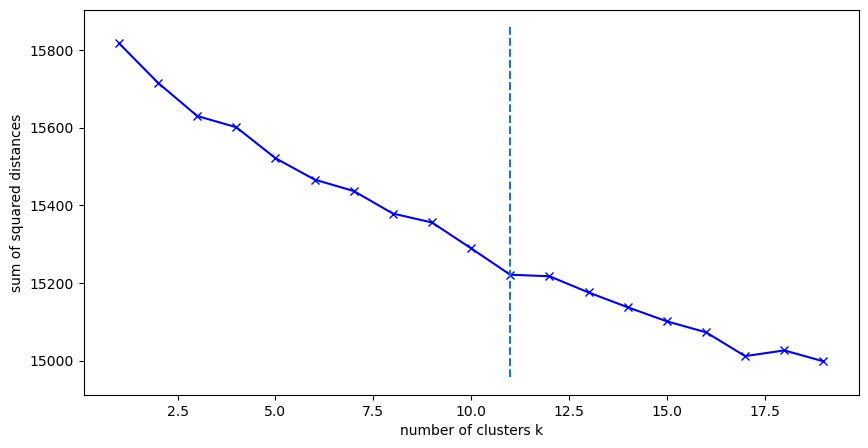

In [ ]:
#answer to question 3.2
dfa = df.copy()
#Cleaning
dfa["new title"] = clean(dfa["title"])

#df for clickbait
df_click = dfa.loc[dfa["label"]== 1]
df_click.reset_index(drop=True, inplace=True)
#df for not clickbait
df_noclick = dfa.loc[dfa["label"]==0]
df_noclick.reset_index(drop=True, inplace=True)

#Vectorization tf_idf  for clickbait
tfidf_vectorizer= TfidfVectorizer(min_df=5, max_df=0.5, norm = "l2") #min_df max_df can be float or int
vectorizer = tfidf_vectorizer.fit_transform(df_click["new title"])
#Creating tf idf matrix
tf_idf = pd.DataFrame (data = vectorizer.toarray(), columns = tfidf_vectorizer.get_feature_names_out())
from kneed import KneeLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster
#Calculate kmeans
inertia = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(tf_idf)
    inertia.append(kmeanModel.inertia_)
    
#Calculating the knee
from kneed import KneeLocator
kn = KneeLocator(K, inertia, curve = "convex", direction = "decreasing")

#Plotting knee
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.xlabel("number of clusters k")
plt.ylabel("sum of squared distances")
plt.plot(K, inertia, "bx-")
plt.vlines(kn.knee, plt.ylim()[0],plt.ylim()[1],linestyles="dashed" )

#Cluster code
clusters = kn.knee
kmeanModel = KMeans(n_clusters = clusters, init = "k-means++", max_iter = 3000, random_state = 0)
mod = kmeanModel.fit_transform(tf_idf)
df_click["k_means"] = kmeanModel.predict(tf_idf)
print("Topics for the click-bait titles")

#Top words per cluster
order_centroids = kmeanModel.cluster_centers_.argsort()[:,::-1]
terms = tfidf_vectorizer.get_feature_names()
dict = []
for i in range(clusters):
    print("%d" % i, sep ="", end = "," ), 
    for ind in order_centroids[i, :15]:
        print (terms[ind], sep ="", end = ",")
    print("")
    
#code
print("Distribution for the click-bait titles clusters")
count = df_click.groupby("k_means").size()
print(count)

Topics for the not click-bait titles
0,wikinews,interviews,candidate,presidential,party,us,independent,dr,upcoming,australian,libertarian,queensland,president,electorate,paralympic,
1,president,former,bush,us,obama,sworn,meets,vice,reelected,barack,elected,says,south,african,iranian,
2,iraq,us,killed,bombings,troops,kills,soldiers,war,claims,violence,alqaeda,dead,least,says,leader,
3,new,york,zealand,jersey,orleans,buffalo,city,us,government,year,day,australian,world,australia,governor,
4,killed,kills,least,crash,bomb,pakistan,suicide,afghanistan,two,explosion,attack,bombing,bomber,blast,three,
5,south,north,korea,korean,africa,nuclear,african,carolina,us,test,talks,missile,says,world,warns,
6,fire,kills,catches,building,killed,england,two,injures,destroyed,new,four,dead,brush,york,apartment,
7,us,senate,court,presidential,supreme,government,says,state,billion,china,secretary,military,obama,afghanistan,bill,
8,dies,age,aged,former,american,actor,british,actress,us,singer,author,last,ru

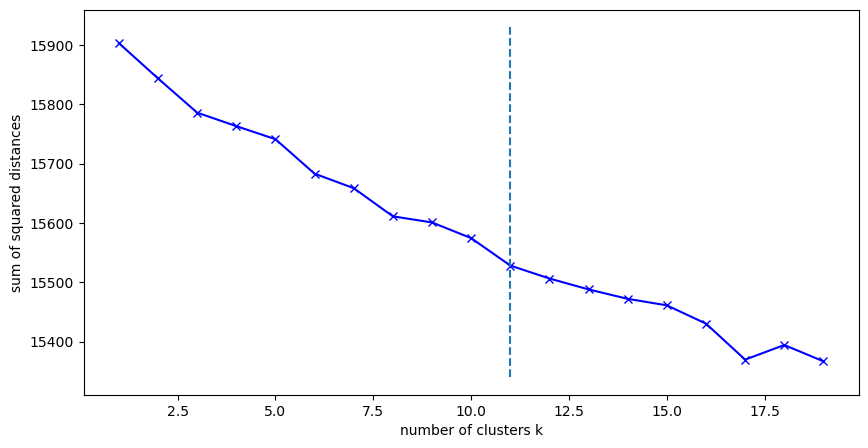

In [ ]:
#Vectorization tf_idf  for clickbait
tfidf_vectorizer= TfidfVectorizer(min_df=5, max_df=0.5, norm = "l2") #min_df max_df can be float or int
vectorizer = tfidf_vectorizer.fit_transform(df_noclick["new title"])
#Creating tf idf matrix
tf_idf = pd.DataFrame (data = vectorizer.toarray(), columns = tfidf_vectorizer.get_feature_names_out())
from kneed import KneeLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster
#Calculate kmeans
inertia = []

K = range(1,20)
for k in K:
    
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(tf_idf)
    inertia.append(kmeanModel.inertia_)
    
#Calculating the knee

from kneed import KneeLocator
kn = KneeLocator(K, inertia, curve = "convex", direction = "decreasing")
#Plotting knee
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.xlabel("number of clusters k")
plt.ylabel("sum of squared distances")
plt.plot(K, inertia, "bx-")
plt.vlines(kn.knee, plt.ylim()[0],plt.ylim()[1],linestyles="dashed" )

#code for K-meansclustering
clusters = kn.knee
kmeanModel = KMeans(n_clusters = clusters, init = "k-means++", max_iter = 3000, random_state = 0)
mod = kmeanModel.fit_transform(tf_idf)
df_noclick["k_means"] = kmeanModel.predict(tf_idf)

print("Topics for the not click-bait titles")
#Top words per cluster
order_centroids = kmeanModel.cluster_centers_.argsort()[:,::-1]
terms = tfidf_vectorizer.get_feature_names()
dict = []
for i in range(clusters):
    print("%d" % i, sep ="", end = "," ), 
    for ind in order_centroids[i, :15]:
        print (terms[ind], sep ="", end = ",")
    print("")

#Printing
print("Distribution for the not click-bait titles clusters")
count = df_noclick.groupby("k_means").size()
print(count)


## Question 3.3

Explain any differences that you see. Does the results yield any insightful results? Also reflect on the analytical process (pros vs. cons). 

*ANSWER:* 

It appears that the topics found in clickbait titles tend to be more focused on entertainment, emotions, holidays, and touristic destinations, while non-clickbait titles tend to cover topics related to real life concerns, news, crime, governments, and official events. This suggests that clickbait titles are more likely to utilize sensational or emotional language to attract readers, while non-clickbait titles may prioritize providing information about current events and issues.
 
The counter vectorizer method is easy to understand and has acceptable performance, but it may give more weight to frequently occurring words that may not be significant. Silge et al. (2017) indicate removing stop words can address this limitation, though some of these words may be more important in certain documents.TF-IDF is a more advanced approach that decreases the weight for commonly used words and increases the weight for less frequently used words in a collection of documents, in order to measure the importance of a word to a document in a collection (Silge et al., 2017). However, it cannot consider the semantics of the text and only works at the lexical level, and it also ignores co-occurrences of words (Shahzad et al., 2018).
 
K-means clustering was used to identify common topics among clickbait titles, with the help of topic modeling to project documents into a topic space (Xie et al., 2017). However, it can be difficult to develop effective clustering methods for high-dimensional datasets due to the curse of dimensionality, and short text clustering poses additional challenges due to data sparsity (Lossio-Ventura et al., 2021).
 
 Determining the correct number of clusters to use in K-means is also a challenge, and Kodinariya et al., (2013) denote that the elbow analysis method can be used to identify the optimal number of clusters, although it is not always reliable and the correct number of clusters depends on the specific case study.
 
Overall, the results provide useful insights and the proposed topics are largely coherent. However, some of the clusters appear to be unbalanced, with more clickbait titles focused on certain topics than others. For example, cluster number 9 for clickbait titles is heavily represented in the distribution. To address this issue, it might be helpful to conduct an analysis to merge some of the topics or even increase the value of K in order to achieve a better balance among the topics.
 
*REFERENCES:* 

Silge, J., Robinson, D. (2017) Text Mining with R. O'Reilly Media

Shahzad, Q., Ramsha, A. (2018)  Text Mining: Use of TF-IDF to Examine the Relevance of Words to Documents International Journal of Computer Applications (0975 – 8887) Volume 181 – No.1

Xie,P. Xing. E.P. () Integrating Document Clustering and Topic Modeling

Lossio-Ventura,J.A., Gonzales, S. (2021). Evaluation of clustering and topic modeling methods over health-related tweets and emails. ​​Stanford Center for Biomedical Informatics Research. Artificial Intelligence In Medicine 117

Kodinariya, T.M, Makwana P.R. (2013) Review on determining number of Cluster in K-Means Clustering. GRMECT Research Center Rajkot - India . International Journal of Advance Research in Computer Science and Management Studies. Volume 1, Issue 6


# Task Four (30 points)

 The file Q4_english_cleaned_lyrics.csv contains the lyrics for 218.209 songs in English. The dataset also has columns for the song title, artist, year, and genre.

## Question 4.1

Your first task is to investigate whether we can build a classifer to identify **pop songs** from other music genres, based on lyrics. In your answer below please make clear 

* which method you use
* justify your choice
* what steps you take

*ANSWER:* 

BERT and DistilBERT have been shown to be effective in learning universal language representations and have achieved excellent results in various language understanding tasks. Akalp et al. (2021) conducted experiments for both single-label and multi-label classification, considering that a song may have one or more genres. The results outperformed current models such as recurrent neural networks.

For these reasons, this study proposes the use of a pretrained DistilBERT model for the task of classifying pop songs using lyrics as input. The data is first preprocessed by lowercasing the words and removing unwanted tokens such as numbers and punctuation. Stop words are not removed because the order and position of words may provide information to the BERT model.

Due to the unbalanced output frequency (more non-pop songs than pop songs), a balancing process was applied. In this case, simple random undersampling of the most frequent category was performed, taking into account that the least frequent class had a sufficient number of more than 23k records. Undersampling methods work by reducing the majority class samples. This reduction can be done randomly in which case it is called random undersampling or it can be done by using some statistical knowledge in which case it is called informed undersampling (Shelke et al. 2017).
This process may introduce some bias as a large number of non-pop examples are randomly dropped. An alternative approach to address this limitation could be to generate synthetic data, which would make the model more robust.

Stratified sampling was used to create train, test, and validation sets and preserve the new output proportions. After generating the subsets, BERT vectorization and pretrained DistilBERT compilation were performed to prepare the model for training with the new data.
Finally, the model was trained for one epoch to prevent overfitting on the train subset, and its performance was evaluated on the test set. An accuracy of 68% and 66% was obtained for non-pop and pop songs in the test set, respectively."

*REFERENCES:* 

Alkalp, H., Bölücü, N., Çiğdem,E.F., Can, B., Yılmaz, S. (2021). Language Representation Models for Music Genre Classification Using Lyrics. Seoul, Republic of Korea.ISEEIE

Shelke, M.S., Deshmukh, P.R, Shandilya, V.K. (2017). A Review on Imbalanced Data Handling Using Undersampling andOversampling Technique.  International Journal of Recent Trends in Engineering & Research (IJRTER). Volume 03, Issue 04;


original distribution False    137561
True      23295
Name: label, dtype: int64
original distribution True     23295
False    23295
Name: label, dtype: int64
Original distribution
1.0    0.5
0.0    0.5
Name: strat_cat, dtype: float64
New train distribution
0.0    0.5
1.0    0.5
Name: strat_cat, dtype: float64
New test distribution
1.0    0.5
0.0    0.5
Name: strat_cat, dtype: float64
Original distribution
1.0    0.5
0.0    0.5
Name: strat_cat, dtype: float64
New test distribution
0.0    0.499893
1.0    0.500107
Name: strat_cat, dtype: float64
New validation distribution
1.0    0.499893
0.0    0.500107
Name: strat_cat, dtype: float64
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 80.7 MB/s 
     |████████████████████████████████| 7.6 MB 59.8 MB/s 


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it fo

73/73 [==============================] - 20s 253ms/step
              precision    recall  f1-score   support

           0       0.68      0.65      0.66      2329
           1       0.66      0.69      0.68      2330

    accuracy                           0.67      4659
   macro avg       0.67      0.67      0.67      4659
weighted avg       0.67      0.67      0.67      4659



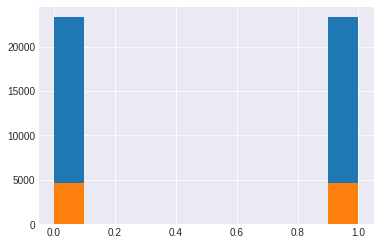

In [2]:
#provide your answer to Question 4.1 below

#Reading
df = pd.read_csv('Q4_english_cleaned_lyrics.csv', sep=',') 

#Dropping not necessary columns
df.drop('Unnamed: 0', inplace=True, axis=1)
# Inspect dataframe

#Basic cleaning
def clean(x):
    #Lowercasing (this function applies per row)
    x = x.apply(lambda x: x.lower())
    #number elimination (str applies for full series)
    x = x.str.replace(r'\d+', '', regex=True)
    # punctuation elminanition
    x = x.str.replace(r'[^\w\s]', '', regex=True)
    #Space removal (stripping)
    x = x.str.replace(r' +', ' ', regex=True)
    #link removal
    x = x.str.replace(r'http\S+', '', regex=True)
    #Returning 
    return x

#Clean
df["lyrics"] = clean(df["lyrics"])

#Changing classification to binary
df["label"] = df["genre"] == "Pop"
print("original distribution",df["label"].value_counts())

# Balancing by undersample
df_pop = df.loc[df["genre"]=="Pop"]
df_no_pop = df.loc[df["genre"]!="Pop"]
df_pop = df_pop[:23295]
df_no_pop  = df_no_pop.sample(n=23295, random_state=0)
strat_test_set = pd.concat([df_pop,df_no_pop] )
print("original distribution", strat_test_set["label"].value_counts())

#Stratified Sampling to generate train, test and validation data
X = strat_test_set.copy()
X["clasif_label"] = strat_test_set["label"]
X["clasif_label"] = X["clasif_label"].apply(lambda x: int(x))
import matplotlib.pyplot as plt
data= X.copy()
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop("index", axis=1,inplace=True ) 
data["y level"] = data["clasif_label"]
# Divide by 1 to limit the number of income categories
data["strat_cat"] = np.ceil(data["y level"] / 1)
#plotting
data["strat_cat"].value_counts()
plt.style.use('seaborn-dark')
data["strat_cat"].hist()
print("Original distribution")
print(data["strat_cat"].value_counts().sort_values(ascending=True) / len(data))

# stratified sampling splitting Train - (Test - val)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["strat_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
print("New train distribution")
print(strat_train_set["strat_cat"].value_counts().sort_values(ascending=True) / len(strat_train_set))
print("New test distribution")
print(strat_test_set["strat_cat"].value_counts().sort_values(ascending=True) / len(strat_test_set))
strat_test_set.head(50)
for set_ in (strat_train_set, strat_test_set):
    set_.drop(["strat_cat", "y level"], axis=1, inplace=True)
    
#Dividing X and Y
X_trainl = strat_train_set["lyrics"]
y_trainl = strat_train_set["clasif_label"]

#Transforming test data with trained vectorizer
X_testl =  strat_test_set["lyrics"]
y_testl =  strat_test_set["clasif_label"]

#Validation split  (from test)
data= strat_test_set.copy()
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop("index", axis=1,inplace=True ) 
data["y level"] = data["clasif_label"]
# Divide by 1 to limit the number of income categories
data["strat_cat"] = np.ceil(data["y level"] / 1)

#plotting
data["strat_cat"].value_counts()
plt.style.use('seaborn-dark')
data["strat_cat"].hist()
print("Original distribution")
print(data["strat_cat"].value_counts().sort_values(ascending=True) / len(data))

# stratified sampling based on the income category. 
from sklearn.model_selection import StratifiedShuffleSplit

#Spliting .5 test and validation set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for train_index, test_index in split.split(data, data["strat_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
print("New test distribution")
print(strat_train_set["strat_cat"].value_counts().sort_values(ascending=True) / len(strat_train_set))
print("New validation distribution")
print(strat_test_set["strat_cat"].value_counts().sort_values(ascending=True) / len(strat_test_set))
strat_test_set.head(50)
for set_ in (strat_train_set, strat_test_set):
    set_.drop(["strat_cat", "y level"], axis=1, inplace=True)

#Train is the test and test is the valid    
    
X_testl = strat_train_set["lyrics"]
y_testl = strat_train_set["clasif_label"]

#Transforming test data with trained vectorizer
X_vall =  strat_test_set["lyrics"]
y_vall =  strat_test_set["clasif_label"]

#Setting all up
X_train = list(pd.DataFrame(X_trainl).lyrics.values)
X_test = list(pd.DataFrame(X_testl).lyrics.values)
X_val = list(pd.DataFrame(X_vall).lyrics.values)
y_train = list(pd.DataFrame(y_trainl).clasif_label.values)
y_test = list(pd.DataFrame(y_testl).clasif_label.values)
y_val = list(pd.DataFrame(y_vall).clasif_label.values)
labels= ["No Pop", "Pop"]

!pip install transformers
import tensorflow as tf

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

#Doing Bert Vectorization
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128) # convert input strings to BERT encodings
test_encodings = tokenizer(X_test, truncation=True, padding=True,  max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(16) # convert the encodings to Tensorflow objects
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(64)

#Bert Compile
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', 
                                                           num_labels=len(labels))
callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, 
                      mode='min', baseline=None, 
                      restore_best_weights=True)]
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

#Train the model
model.fit(train_dataset, 
            epochs=1,
          callbacks=callbacks, 
          validation_data=val_dataset,
           batch_size=16)

#Evaluating performance
import numpy as np
from sklearn.metrics import classification_report 

logits = model.predict(test_dataset)
y_preds = np.argmax(logits[0], axis=1)
print(classification_report(y_test, y_preds))


## Question 4.2 

Then consider the new lyrics below (see also file Q4_new_lyrics_text for copy and paste). To what extent can these be considered as a “stereotypical” pop-song in your dataset? Provide an answer based on the results of relevant data analyses and the lyrics themselves. 





<sub><sup>The sky breaks open and the rain falls down<sub><sup>  

<sub><sup>Oh, and the pain is blinding<sub><sup>  

<sub><sup>But we carry on... <sub><sup>    

<sub><sup>Seems like the end of everything<sub><sup>  

<sub><sup>When the one you love<sub><sup>   

<sub><sup>Turns their back on you<sub><sup>  

<sub><sup>And the whole world falls down on you...<sub><sup>   

<sub><sup>It's the end of the world<sub><sup>   

<sub><sup>It's the end of the world<sub><sup>   

<sub><sup>Well, I'm holding on...<sub><sup>  

<sub><sup>But the world keeps dragging me down...<sub><sup>   

<sub><sup>It's the end of the world<sub><sup>   

<sub><sup>It's the end of the world<sub><sup>   

<sub><sup>Well, I'm holding on...<sub><sup>   

<sub><sup>But the world keeps dragging me down...<sub><sup>   

<sub><sup>I got my heart on lockdown<sub><sup>   

<sub><sup>And my eyes on the lookout<sub><sup>   

<sub><sup>But I just know that I'm<sub><sup>   

<sub><sup>Never gonna win this<sub><sup>   

<sub><sup>They can keep the lights on<sub><sup>   

<sub><sup>They can keep the music loud<sub><sup>   

<sub><sup>I don't need anything<sub><sup>   

<sub><sup>When I got my music<sub><sup>   

<sub><sup>And I'm holding on...<sub><sup>   

<sub><sup>The sky breaks open and the rain falls down<sub><sup>   

<sub><sup>And the pain is blinding<sub><sup>   

<sub><sup>But we carry on<sub><sup>   

<sub><sup>(They tell you lies)<sub><sup>   

<sub><sup>I'm holding on...<sub><sup>   

<sub><sup>(They tell you lies)<sub><sup>  

<sub><sup>The sky breaks open and the rain falls down<sub><sup>   

<sub><sup>Oh, and the pain is blinding<sub><sup>   

<sub><sup>But we carry on...<sub><sup>   

<sub><sup>Seems like the end of everything   

<sub><sup>When the one you love   

<sub><sup>Turns their back on you   

<sub><sup>And the whole world falls down on you...   

<sub><sup>It's the end of the world   

<sub><sup>It's the end of the world   

<sub><sup>Well, I'm holding on...  

<sub><sup>But the world keeps dragging me down...   

<sub><sup>It's the end of the world   

<sub><sup>It's the end of the world   

<sub><sup>Well, I'm holding on...   

<sub><sup>But the world keeps dragging me down...   

<sub><sup>I got my heart on lockdown   

<sub><sup>And my eyes on the lookout   

<sub><sup>But I just know that I'm   

<sub><sup>Never gonna win this   

<sub><sup>They can keep the lights on   

<sub><sup>They can keep the music loud   

<sub><sup>I don't need anything   

<sub><sup>When I got my music    

<sub><sup>And I'm holding on...   

<sub><sup>The sky breaks open and the rain falls down   

<sub><sup>And the pain is blinding   

<sub><sup>But we carry on   

<sub><sup>(They tell you lies)<sub><sup>   

<sub><sup>I'm holding on...<sub><sup>    
 
<sub><sup>(They tell you lies)<sub><sup>

*ANSWER:* 

To evaluate the degree of belonging of a test song to the pop song genre, the test song is first cleaned in the same way as the training data. After that, the song was classified by the model as a pop song.

 Prediction logits were then obtained from the model to get a probability value of how certain the model "thinks" the song is a pop song. The results indicated that this test song has a 65.7% probability of being a pop song. However, these results also show that this is not a typical pop song, as the probability is close to the average accuracy of the model for the pop song category.

 If an increase in pop song classification accuracy was desired using this created model, it would be necessary to modify the decision threshold, but this would reduce the accuracy of non-pop song classification as a result.


In [5]:
#Inserting lyrics
text = "The sky breaks open and the rain falls down Oh, and the pain is blinding\
But we carry on...\
Seems like the end of everything\
When the one you love\
Turns their back on you\
And the whole world falls down on you...\
It's the end of the world\
It's the end of the world\
Well, I'm holding on...\
But the world keeps dragging me down...\
It's the end of the world\
It's the end of the world\
Well, I'm holding on...\
But the world keeps dragging me down...\
I got my heart on lockdown\
And my eyes on the lookout\
But I just know that I'm\
Never gonna win this\
They can keep the lights on\
They can keep the music loud\
I don't need anything\
When I got my music\
And I'm holding on...\
The sky breaks open and the rain falls down\
And the pain is blinding\
But we carry on\
(They tell you lies)\
I'm holding on...\
(They tell you lies)\
The sky breaks open and the rain falls down\
Oh, and the pain is blinding\
But we carry on...\
Seems like the end of everything\
When the one you love\
Turns their back on you\
And the whole world falls down on you...\
It's the end of the world\
It's the end of the world\
Well, I'm holding on...\
But the world keeps dragging me down...\
It's the end of the world\
It's the end of the world\
Well, I'm holding on...\
But the world keeps dragging me down...\
I got my heart on lockdown\
And my eyes on the lookout\
But I just know that I'm\
Never gonna win this\
They can keep the lights on\
They can keep the music loud\
I don't need anything\
When I got my music \
And I'm holding on...\
The sky breaks open and the rain falls down\
And the pain is blinding\
But we carry on\
(They tell you lies)\
I'm holding on...\
(They tell you lies)"


#cleaning text
def clean_text(x):
    #Lowercasing (this function applies per row)
    x = x.lower()
    #number elimination (str applies for full series)
    x = re.sub(r'\d+', '',x)
    # punctuation elminanition
    x = re.sub(r'[^\w\s]', '',x)
    #Space removal (stripping)
    x = re.sub(r' +', ' ', x)
    #link removal
    x = re.sub(r'http\S+', '', x)
    #Returning 
    return x

#Cleaning text
text = clean_text(text)
new_examples = [text]
#Evaluating
examples_encodings = tokenizer(new_examples, truncation=True, padding=True)
examples_encodings = tf.data.Dataset.from_tensor_slices((
                    dict(examples_encodings)
                      )).batch(64)
pred_logits = model.predict(examples_encodings)

for i, logits in enumerate(pred_logits[0]):
    prediction = np.argmax(logits)
    print("Prediction for this song" ,labels[prediction])

#Getting the probabilities of the evaluation

softmax = lambda x : np.exp(x)/sum(np.exp(x))
for i, logits in enumerate(pred_logits[0]):
    proba = softmax(logits)
    probability_not_pop = proba[0]
    probability_pop = proba[1]
    print("This song {}% not pop song; {}% pop song".format(
                                                    round(probability_not_pop, 3),
                                                    round(probability_pop, 3)))


1/1 [==============================] - 1s 1s/step
Prediction for this song Pop
This song 0.34200000762939453% not pop song; 0.6579999923706055% pop song
